In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
import math
from xgboost import XGBRegressor

In [2]:
# Previous lines are to test the Word2Vec model
# Code starts here
# Reading Hansen and SMILES data from gpHSP
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')

mol_smiles = gpHSP_data['SMILES']
hansen_d = gpHSP_data['hansen_d']
hansen_p = gpHSP_data['hansen_p']
hansen_h = gpHSP_data['hansen_h']
mol_number = gpHSP_data['number']
mol_name = gpHSP_data['Molecule']

hansen_total = np.sqrt((hansen_d*hansen_d + hansen_p*hansen_p + hansen_h*hansen_h))

In [3]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('mol2vec/examples/models/model_300dim.pkl')

In [4]:
# Extraction of identifiers from molecules
mmm = [Chem.MolFromSmiles(x) for x in mol_smiles]
aa_sentences = [mol2alt_sentence(x, 1) for x in mmm]

#Generate "molecular sentences" that are then used to featurize the molecules 
#(i.e. vectors of identifiers are extracted from Mol2vec model and summed up)
 
aa_mol2vec = [DfVec(x) for x in sentences2vec(aa_sentences, model, unseen='UNK')]

In [5]:
np_aa_mol2vec = np.array([x.vec for x in aa_mol2vec])
print(np_aa_mol2vec.shape)

(1183, 300)


In [6]:
from sklearn import preprocessing

scaler= preprocessing.StandardScaler()
np_m2v = scaler.fit_transform(np_aa_mol2vec)

Fold:1, Train set: 985, Test set:198
2.072953380109517
3.260574987160604
0.5585019843081884


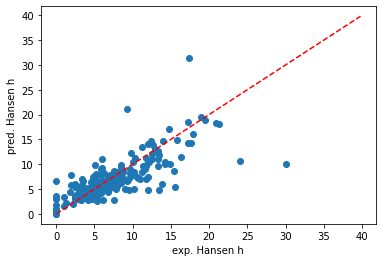

Fold:2, Train set: 986, Test set:197
2.2962717677583577
3.6554692372336537
0.5836034487631547


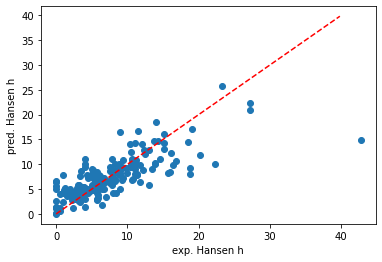

Fold:3, Train set: 986, Test set:197
2.077307620879054
3.265398063205305
0.6260539804440257


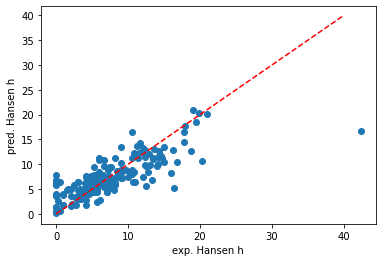

Fold:4, Train set: 986, Test set:197
2.3285731329908828
3.453458514411301
0.5365876385272608


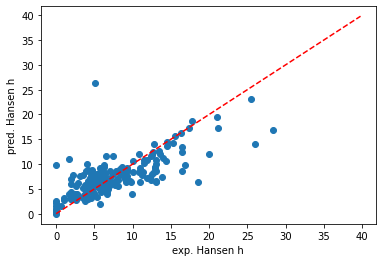

Fold:5, Train set: 986, Test set:197
2.0705054668799456
2.9043971800278654
0.6178755473824231


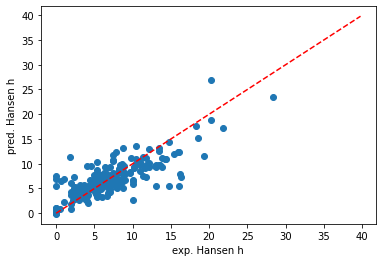

Fold:6, Train set: 986, Test set:197
2.075052113518554
3.292383660008854
0.6089372099420582


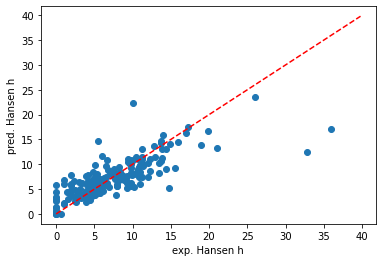

In [7]:
# split the data into 6 folds.  
# use'kf'(KFold splitting stratergy) object as input to cross_val_score() method
kf =KFold(n_splits=6, shuffle=True, random_state=42)

cnt = 1

# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(np_m2v, hansen_h):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
  
    m2v_train, m2v_test = np_m2v[train_index], np_m2v[test_index]
    hansen_train, hansen_test = hansen_h[train_index], hansen_h[test_index]
    index_train, index_test = mol_number[train_index], mol_number[test_index]
    smiles_train, smiles_test = mol_smiles[train_index], mol_smiles[test_index]
    
    # training model
    model = XGBRegressor().fit(m2v_train, hansen_train)
    hansen_pred = model.predict(m2v_test)

    print(mean_absolute_error (hansen_test, hansen_pred))
    print(math.sqrt(mean_squared_error(hansen_test, hansen_pred)))
    print(r2_score (hansen_test, hansen_pred))

    pd_hansen_pred = pd.DataFrame(hansen_pred, columns=["pred"])
    xg_output = pd.concat((index_test.reset_index(), smiles_test.reset_index(), hansen_test.reset_index(), pd_hansen_pred), ignore_index=True, axis=1)
    xg_output.to_csv(f'mol2vec_xgboost_hansen_h_fold_{cnt}.csv')

    ln = np.arange(0, 40, 0.2)
    plt.plot(ln, ln,'r--')
    plt.scatter(hansen_test, hansen_pred)
    plt.plot(color='green')

    plt.xlabel('exp. Hansen h')
    plt.ylabel('pred. Hansen h')
    plt.show()
    
    cnt += 1
    